In [23]:
# libraries
import copy #用于复制对象，包括深拷贝和浅拷贝
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12] #设置Matplotlib绘图的默认大小为18*12英寸

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics #提供了计算损失地形的指标

In [24]:
#训练超参数
IN_DIM = 28 * 28 #图像大小为28*28
OUT_DIM = 10 #输出维度为10
LR = 10 ** -2 #学习率
BATCH_SIZE = 512 #批量大小
EPOCHS = 25 #训练轮数
#等高线图分辨率，步长越小，生成的等高线图越精细。假设有一个二维函数f(x,y)，steps决定了x和y方向上生成多少个点来绘制等高线图
STEPS = 40

In [25]:
class MLPSmall(torch.nn.Module):
    """有一个隐藏层的简单前馈神经网络"""
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 32)
        self.linear_2 = torch.nn.Linear(32, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.softmax(self.linear_2(h), dim=1)


class Flatten(object):
    """将一个PIL图像转换为一维numpy数组"""
    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten()    
    

def train(model, optimizer, criterion, train_loader, epochs):
    """根据给定的优化方法、损失函数等训练给定的模型"""
    model.train()
    # train model
    for _ in tqdm(range(epochs), 'Training'):
        for count, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, y = batch

            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    model.eval()

In [26]:
#下载数据集并设置数据加载器
mnist_train = datasets.MNIST(root='../data', train=True, download=True, transform=Flatten())
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=False)

#定义模型
model = MLPSmall(IN_DIM, OUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [27]:
#存储参数空间中的初始点（训练前模型的副本）
model_initial = copy.deepcopy(model)

In [28]:
train(model, optimizer, criterion, train_loader, EPOCHS)

model_final = copy.deepcopy(model) #存储参数空间中的最终点（训练后模型的副本）

Training: 100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


In [ ]:
class Plot_loss_landscape():
    """有一个隐藏层的简单前馈神经网络"""
    def __init__(self, model_initial, model_final, X, y, loss_func, STEPS):
        super().__init__()
        self.model_initial = model_initial
        self.model_final = model_final
        self.X = X
        self.y = y
        self.STEPS = STEPS
        self.loss_func = loss_func

        self.metric = loss_landscapes.metrics.Loss(self.loss_func, self.X, self.y) #创建一个用于评估模型损失的对象，接受三个数据：损失函数、输入数据x和标签y

        #用于绘制平面图计算损失数据，这里用于在两个模型之间进行线性插值，并计算插值过程中每一步的损失，需要传入初始模型、最终模型、用于计算损失的Loss对象和插值步数
        self.loss_data = loss_landscapes.linear_interpolation(self.model_initial, self.model_final, self.metric, STEPS, deepcopy_model=True) #返回一个包含插值过程中每一步损失的数据数组loss_data

        #用于绘制等高线图和三维图，生成一个随机平面上的损失数据，传入参数为训练好的模型、用于计算损失的Loss对象、平面上一个维度的步数（会在这个维度上生成十个点）、STEPs表示另一个维度的步数和归一化方法   
        self.loss_data_fin = loss_landscapes.random_plane(self.model_final, self.metric, 10, self.STEPS, normalization='filter', deepcopy_model=True)
        #这里三维图和等高线图的数据是一样的，只是维度不同，三维图是二维数据，等高线图是一维数据，他们的xy轴分别表示参数空间的一个维度，z轴表示损失值的变化范围
        #xy轴变化了steps个时间步，也就是变化了40次，变成什么是随机的
        #参数空间是一个多维空间，每个空间对应一个模型参数，对于有n个参数的模型，参数空间是一个n维空间。
        #参数空间的两个维度，意味着固定其他参数，选择两个参数变化对损失函数的影响，参数空间一个点表示一组特定的模型参数值。这两个参数的选择方法有随机选择、重要性选择、主成分分析和手动选择等等
    
    #绘制线性插值的损失图
    #这里绘制的图像，x轴为1/STEPS * i，从0到1，代表从初始模型到最终模型的损失变化过程，y轴为损失值的具体数值，数据是loss_data
    #如果损失曲线是平滑的，说明优化过程是稳定的，如果损失曲线是波动的，说明优化过程是不稳定的
    def plot_linear_interpolation_of_loss(self):
        plt.plot([1/self.STEPS * i for i in range(self.STEPS)], self.loss_data) #绘制loss_data中的数据，横坐标为插值系数，纵坐标为损失值
        plt.title('Linear Interpolation of Loss')
        plt.xlabel('Interpolation Coefficient')
        plt.ylabel('Loss')
        axes = plt.gca()
        # axes.set_ylim([2.300,2.325])
        plt.show()

    #绘制训练后模型周围的损失等高线图
    def plot_loss_contours_arround_trained_model(self):
        plt.contour(self.loss_data_fin, levels=1000) #绘制等高线的函数，数据为loss_data_fin（二维），levels表示等高线的数量
        plt.title('Loss Contours around Trained Model')
        plt.show()

    #损失景观的三维图像
    def plot_surface_of_loss_landscape(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        #生成两个二维数组X和Y，STEPs表示每个维度上的步数，
        X = np.array([[j for j in range(self.STEPS)] for i in range(self.STEPS)])
        Y = np.array([[i for _ in range(self.STEPS)] for i in range(self.STEPS)])
        #在3D坐标轴ax上绘制表面图，X和Y表示数据的坐标，loss_data_fin表示数据的值，rstride和cstride表示行和列的步长，cmap表示颜色映射，edgecolor表示边缘颜色
        ax.plot_surface(X, Y, self.loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none') 
        ax.set_title('Surface Plot of Loss Landscape')
        fig.show()

In [30]:
x, y = iter(train_loader).__next__() #从数据加载器中获取一个批次的数据，x为图像数据，y为标签
landscape = Plot_loss_landscape(model_initial, model_final, x, y, torch.nn.CrossEntropyLoss(), STEPS)

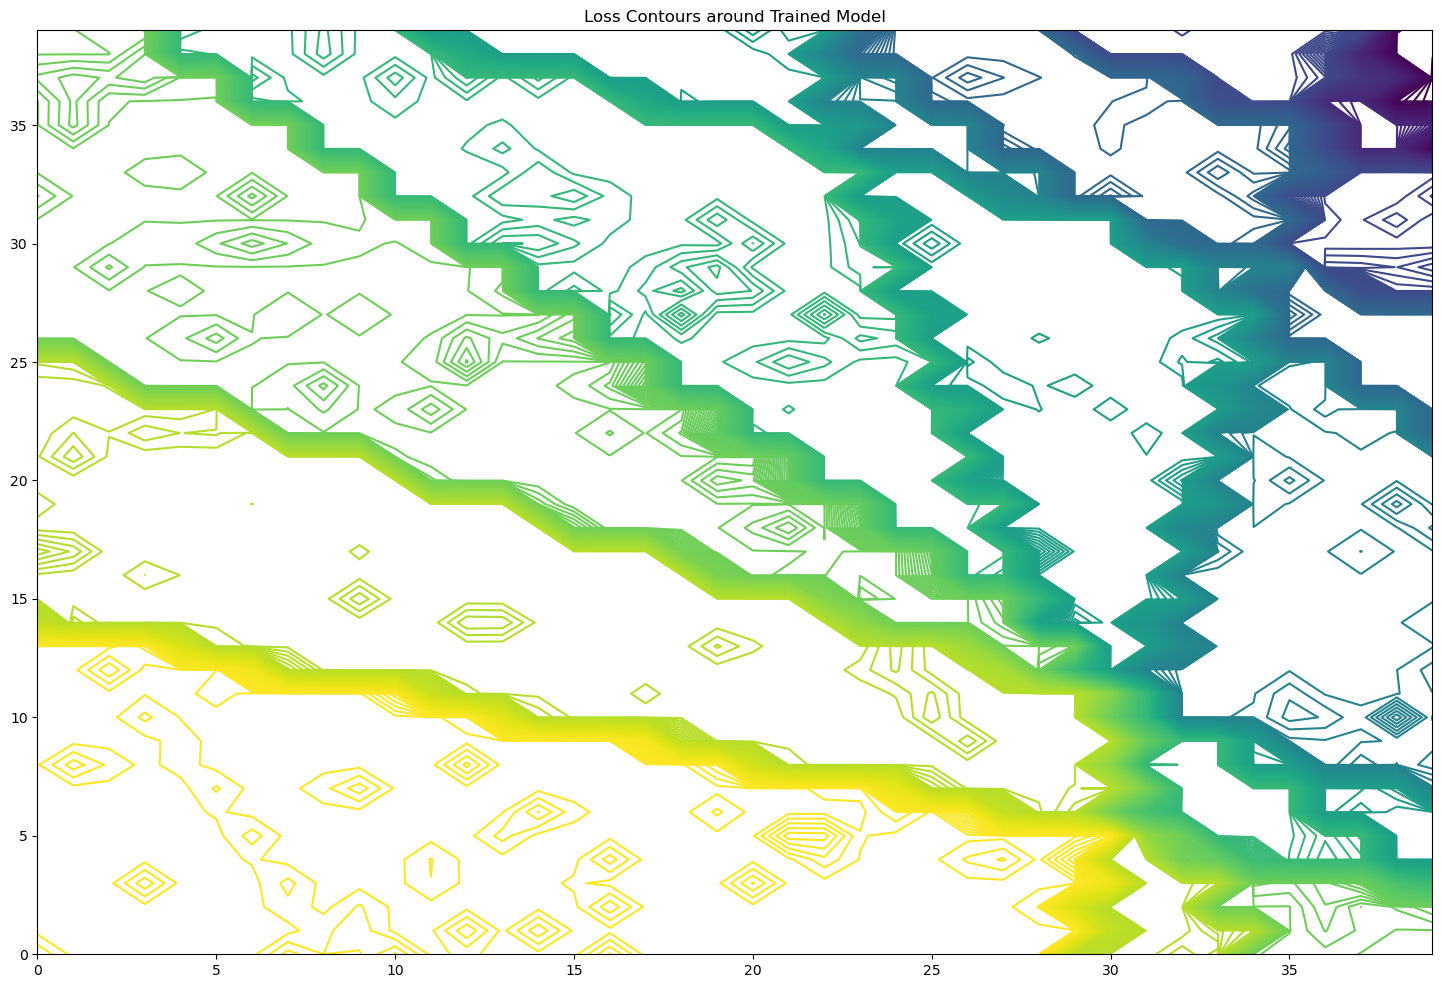

In [35]:
landscape.plot_loss_contours_arround_trained_model()

C:\Users\lcy\AppData\Local\Temp\ipykernel_39576\4022703881.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


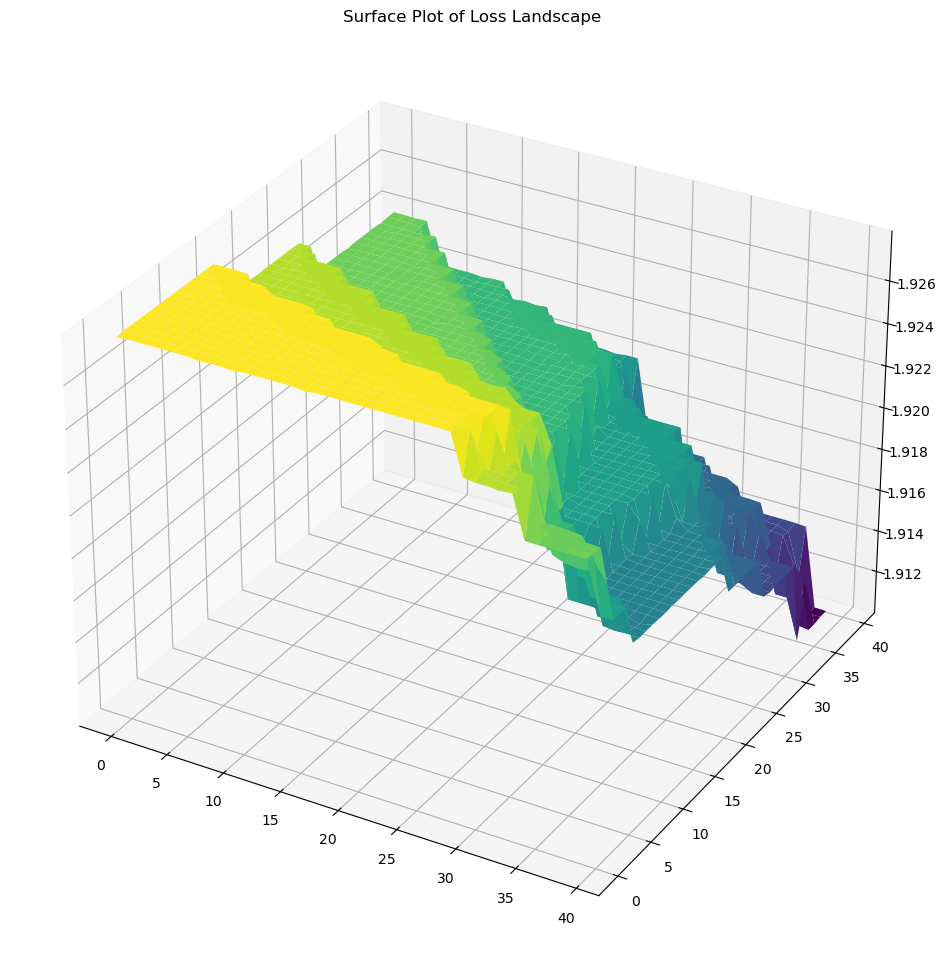

In [36]:
landscape.plot_surface_of_loss_landscape()